# Gaussian process classifiers and CNN uncertainty

## To do:
- With and without learning phase
- Print prediciton probability difference between correct and second best
- Then print prediction probability difference between expected output and given output for the incorrect examples

## Train CNN on MNIST

In [21]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np

from sklearn.metrics import classification_report
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
model = keras.models.load_model('my_model.h5')

In [23]:
#Load training data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_classes = 10
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [24]:
#Handle Theano and Tensorflow data format
img_rows, img_cols = 28,28

print("Image data format: {}".format(K.image_data_format()))

if K.image_data_format() == 'channel_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Image data format: channels_last


In [25]:
train_model = False
if train_model:
    batch_size = 128
    epochs = 12

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape)) 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    model.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test_one_hot))

In [31]:
#evaluate CNN
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))
cnn_predictions = np.argmax(model.predict(X_test), axis=1)
print(classification_report(cnn_predictions, y_test))

Test loss: 0.028256796755890535
Test accuracy: 0.9906
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       990
          1       1.00      0.99      0.99      1137
          2       0.99      0.99      0.99      1036
          3       1.00      0.99      0.99      1021
          4       0.99      0.99      0.99       976
          5       0.99      0.99      0.99       891
          6       0.99      0.99      0.99       953
          7       0.99      0.99      0.99      1024
          8       0.99      0.99      0.99       967
          9       0.99      0.99      0.99      1005

avg / total       0.99      0.99      0.99     10000



In [ ]:
def get_ith_layer_output(model, X, i, mode='test'):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
    return layer_output

In [ ]:
last_layer_train_outputs = get_ith_layer_output(model, X_train, -2)

In [ ]:
last_layer_test_outputs = get_ith_layer_output(model, X_test, -2)

##  Use a GP to predict output with uncertainty

In [9]:
print(last_layer_train_outputs.shape)
print(y_train.shape)

(60000, 128)
(60000,)


In [22]:
kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel, multi_class="one_vs_rest").fit(last_layer_train_outputs[:1000],y_train[:1000])

In [23]:
predictions = gpc_rbf_isotropic.predict(last_layer_test_outputs)

In [21]:
print(classification_report(predictions, y_test))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      1001
          1       1.00      0.94      0.97      1210
          2       0.91      0.99      0.95       944
          3       0.96      0.99      0.97       980
          4       0.98      0.97      0.97       989
          5       0.89      0.99      0.94       798
          6       0.98      0.95      0.97       990
          7       0.95      0.96      0.96      1015
          8       0.89      0.99      0.94       875
          9       0.99      0.83      0.90      1198

avg / total       0.96      0.95      0.95     10000



In [24]:
print(classification_report(predictions, y_test))

             precision    recall  f1-score   support

          0       0.99      0.98      0.98       984
          1       0.99      0.99      0.99      1136
          2       0.98      0.98      0.98      1031
          3       0.97      0.99      0.98       993
          4       0.97      0.99      0.98       965
          5       0.98      0.97      0.98       902
          6       0.99      0.98      0.98       962
          7       0.96      0.98      0.97      1017
          8       0.95      0.97      0.96       961
          9       0.98      0.94      0.96      1049

avg / total       0.98      0.98      0.98     10000



In [41]:
predictions_proba = gpc_rbf_isotropic.predict_proba(last_layer_test_outputs)
predictions_proba.shape

(10000, 10)

In [44]:
correct_indices = np.argwhere(predictions == y_test)

In [38]:
print(correct_indices.shape)


(9764, 1)
(236, 1)


(array([  5.,   1.,   4.,   5.,  11.,  12.,  20.,  19.,  22.,  31.,  32.,
         46.,  54.,  63.,  58.,  74.,  90., 113., 119., 133., 164., 178.,
        220., 292., 356., 435., 486., 520., 507., 567., 589., 532., 529.,
        457., 464., 411., 332., 270., 264., 216., 183., 167., 158., 143.,
        118., 113.,  88.,  50.,  32.,  11.]),
 array([0.1665273 , 0.17794037, 0.18935343, 0.2007665 , 0.21217956,
        0.22359262, 0.23500569, 0.24641875, 0.25783182, 0.26924488,
        0.28065795, 0.29207101, 0.30348407, 0.31489714, 0.3263102 ,
        0.33772327, 0.34913633, 0.3605494 , 0.37196246, 0.38337552,
        0.39478859, 0.40620165, 0.41761472, 0.42902778, 0.44044085,
        0.45185391, 0.46326698, 0.47468004, 0.4860931 , 0.49750617,
        0.50891923, 0.5203323 , 0.53174536, 0.54315843, 0.55457149,
        0.56598455, 0.57739762, 0.58881068, 0.60022375, 0.61163681,
        0.62304988, 0.63446294, 0.645876  , 0.65728907, 0.66870213,
        0.6801152 , 0.69152826, 0.70294133, 0.

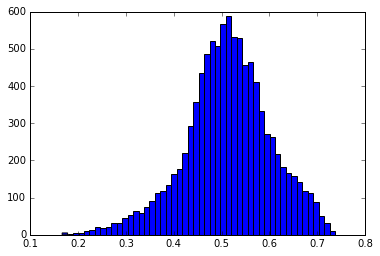

In [122]:
correct_probabilitis = np.max(predictions_proba[correct_indices].reshape(-1, 10), axis=1)
plt.hist(correct_probabilitis, bins=50)

[0.25262906 0.32661127 0.1816585  0.22869449 0.18348076 0.14792772
 0.15582759 0.23528749 0.20546723 0.22288029]


(array([ 1.,  1.,  2.,  0.,  2.,  2.,  2.,  5.,  1.,  6.,  4.,  5.,  7.,
         6.,  6.,  5.,  4.,  7.,  4.,  5.,  8.,  6.,  8.,  5.,  7., 10.,
        17.,  6.,  6.,  7., 11.,  9.,  6., 10.,  8.,  3.,  6.,  5.,  5.,
         5.,  2.,  1.,  1.,  4.,  1.,  1.,  0.,  2.,  0.,  1.]),
 array([0.04434977, 0.05034103, 0.05633229, 0.06232355, 0.06831481,
        0.07430607, 0.08029733, 0.08628859, 0.09227985, 0.09827111,
        0.10426237, 0.11025363, 0.11624489, 0.12223615, 0.12822741,
        0.13421867, 0.14020993, 0.14620119, 0.15219245, 0.15818371,
        0.16417497, 0.17016623, 0.17615748, 0.18214874, 0.18814   ,
        0.19413126, 0.20012252, 0.20611378, 0.21210504, 0.2180963 ,
        0.22408756, 0.23007882, 0.23607008, 0.24206134, 0.2480526 ,
        0.25404386, 0.26003512, 0.26602638, 0.27201764, 0.2780089 ,
        0.28400016, 0.28999142, 0.29598268, 0.30197394, 0.3079652 ,
        0.31395645, 0.31994771, 0.32593897, 0.33193023, 0.33792149,
        0.34391275]),
 <a list of 50

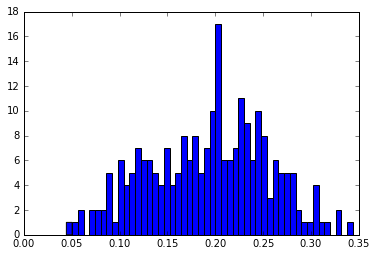

In [135]:
#compute probability assigned to the correct label in missclassified examples
incorrect_indices = np.argwhere(predictions != y_test)
incorrect_probabilities = predictions_proba[incorrect_indices].reshape(-1, 10)
correct_predictions = y_test[incorrect_indices].reshape(-1)
incorrect_probabilities_correct_label = incorrect_probabilities[np.arange(len(correct_predictions)), correct_predictions]
print(incorrect_probabilities_correct_label[:10])
plt.hist(incorrect_probabilities_correct_label, bins=50)

[0.29355185 0.32900504 0.21293704 0.25253253 0.29585329 0.3219425
 0.46849576 0.2641355  0.3750401  0.23265359]


(array([ 1.,  2.,  3.,  2.,  6.,  5.,  5.,  6.,  8.,  7., 15., 12., 15.,
         5., 12.,  9., 13.,  5.,  7.,  8.,  9.,  8.,  8.,  3.,  4., 10.,
         8.,  4.,  1.,  6.,  6.,  3.,  5.,  0.,  1.,  1.,  0.,  1.,  2.,
         1.,  1.,  2.,  2.,  0.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([0.16524893, 0.17313687, 0.18102482, 0.18891276, 0.19680071,
        0.20468865, 0.2125766 , 0.22046454, 0.22835249, 0.23624043,
        0.24412838, 0.25201633, 0.25990427, 0.26779222, 0.27568016,
        0.28356811, 0.29145605, 0.299344  , 0.30723194, 0.31511989,
        0.32300783, 0.33089578, 0.33878372, 0.34667167, 0.35455961,
        0.36244756, 0.37033551, 0.37822345, 0.3861114 , 0.39399934,
        0.40188729, 0.40977523, 0.41766318, 0.42555112, 0.43343907,
        0.44132701, 0.44921496, 0.4571029 , 0.46499085, 0.4728788 ,
        0.48076674, 0.48865469, 0.49654263, 0.50443058, 0.51231852,
        0.52020647, 0.52809441, 0.53598236, 0.5438703 , 0.55175825,
        0.55964619]),
 <a list of 50

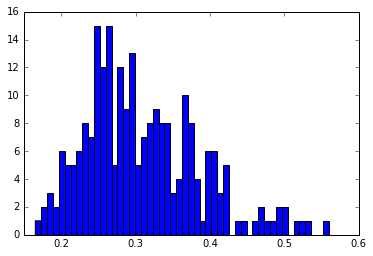

In [132]:
#highest probability assigned in mislabbeled examples
incorrect_indices = np.argwhere(predictions != y_test)
incorrect_probabilities = np.max(predictions_proba[incorrect_indices].reshape(-1, 10), axis=1)
print(incorrect_probabilities[:10])
plt.hist(incorrect_probabilities, bins=50)